In [1]:
!git clone https://github.com/TalwalkarLab/leaf.git
%cd leaf
# In leaf/data/shakespeare/preprocess/get_data.sh we should change the link
# to http://www.gutenberg.org/files/100/old/old/1994-01-100.zip and save that script

Cloning into 'leaf'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 782 (delta 1), reused 2 (delta 0), pack-reused 776 (from 1)
Receiving objects: 100% (782/782), 6.78 MiB | 7.56 MiB/s, done.
Resolving deltas: 100% (372/372), done.
/content/leaf


In [2]:
!pip install -r requirements.txt
%cd data/shakespeare
!./preprocess.sh --sf 0.2 -t sample -tf 0.8
%cd ../..

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==1.13.1
/content/leaf/data/shakespeare
--2025-01-22 13:44:10--  http://www.gutenberg.org/files/100/old/old/1994-01-100.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47,

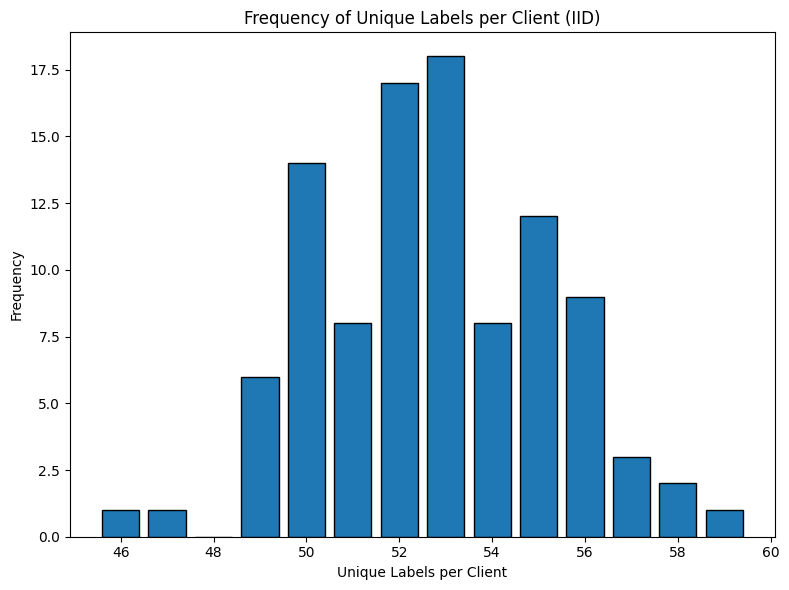

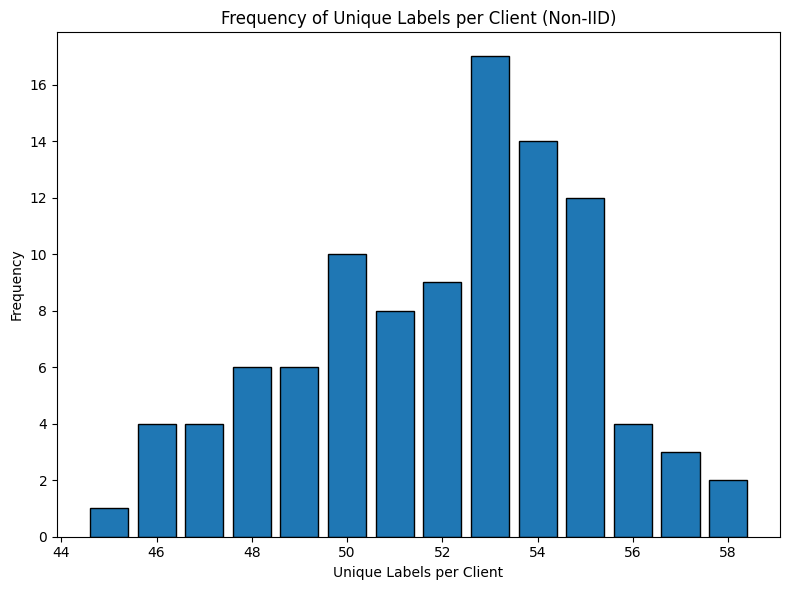

In [6]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Paths to the train and test datasets
train_data_path = '/content/leaf/data/shakespeare/data/train/all_data_train_9.json'
test_data_path = '/content/leaf/data/shakespeare/data/test/all_data_test_9.json'

# Function to split data IID
def split_data_iid(train_data, test_data, n_clients=100, crop_amount=2000):
    clients = random.sample(
        [user for user, data in train_data['user_data'].items() if len(data['x']) >= crop_amount],
        n_clients
    )

    train_split = {"users": [], "user_data": {}, "num_samples": []}
    test_split = {"users": [], "user_data": {}, "num_samples": []}

    for client in clients:
        indices = np.random.choice(len(train_data['user_data'][client]['x']), crop_amount, replace=False)
        train_split['users'].append(client)
        train_split['user_data'][client] = {
            'x': [train_data['user_data'][client]['x'][i] for i in indices],
            'y': [train_data['user_data'][client]['y'][i] for i in indices]
        }
        train_split['num_samples'].append(crop_amount)

        test_split['users'].append(client)
        test_split['user_data'][client] = {
            'x': test_data['user_data'][client]['x'],
            'y': test_data['user_data'][client]['y']
        }
        test_split['num_samples'].append(len(test_data['user_data'][client]['x']))

    return train_split, test_split

# Function to split data non-IID
def split_data_noniid(train_data, test_data, n_clients=100, crop_amount=2000):
    clients = random.sample(
        [user for user, data in train_data['user_data'].items() if len(data['x']) >= crop_amount],
        n_clients
    )

    train_split = {"users": [], "user_data": {}, "num_samples": []}
    test_split = {"users": [], "user_data": {}, "num_samples": []}

    for client in clients:
        train_split['users'].append(client)
        train_split['user_data'][client] = {
            'x': train_data['user_data'][client]['x'][:crop_amount],
            'y': train_data['user_data'][client]['y'][:crop_amount]
        }
        train_split['num_samples'].append(crop_amount)

        test_split['users'].append(client)
        test_split['user_data'][client] = {
            'x': test_data['user_data'][client]['x'],
            'y': test_data['user_data'][client]['y']
        }
        test_split['num_samples'].append(len(test_data['user_data'][client]['x']))

    return train_split, test_split

# Function to save data splits to JSON
def save_data_split(path, data):
    with open(path, 'w') as f:
        json.dump(data, f)

# Function to plot histograms
def plot_histograms(train_split, iid=True):
    unique_label_counts = [len(set(data['y'])) for data in train_split['user_data'].values()]
    plt.figure(figsize=(8, 6))
    plt.hist(unique_label_counts, bins=np.arange(min(unique_label_counts), max(unique_label_counts) + 2) - 0.5, edgecolor='black', rwidth=0.8)
    plt.title(f"Frequency of Unique Labels per Client ({'IID' if iid else 'Non-IID'})")
    plt.xlabel("Unique Labels per Client")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"{'iid' if iid else 'noniid'}_label_distribution.png")
    plt.show()

# Main execution
if __name__ == "__main__":
    with open(train_data_path, 'r') as f:
        train_data = json.load(f)
    with open(test_data_path, 'r') as f:
        test_data = json.load(f)

    # Generate IID and Non-IID splits
    train_iid_split, test_iid_split = split_data_iid(train_data, test_data)
    train_noniid_split, test_noniid_split = split_data_noniid(train_data, test_data)

    # Save splits to JSON
    save_data_split('/content/leaf/train_iid_split.json', train_iid_split)
    save_data_split('/content/leaf/test_iid_split.json', test_iid_split)
    save_data_split('/content/leaf/train_noniid_split.json', train_noniid_split)
    save_data_split('/content/leaf/test_noniid_split.json', test_noniid_split)

    # Plot histograms
    plot_histograms(train_iid_split, iid=True)
    plot_histograms(train_noniid_split, iid=False)
